## 1.Library import

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
np.set_printoptions(linewidth=200)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import other libraries
import os, re, string
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna

data_path = './titanic/'

## 2.Read data

In [2]:
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")
df_alldata = pd.concat([df_train, df_test], sort=False, ignore_index=True) #前処理用に結合データを生成
print(df_train.shape, df_test.shape, df_alldata.shape)

(891, 12) (418, 11) (1309, 12)


In [3]:
df_alldata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3.Check Data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

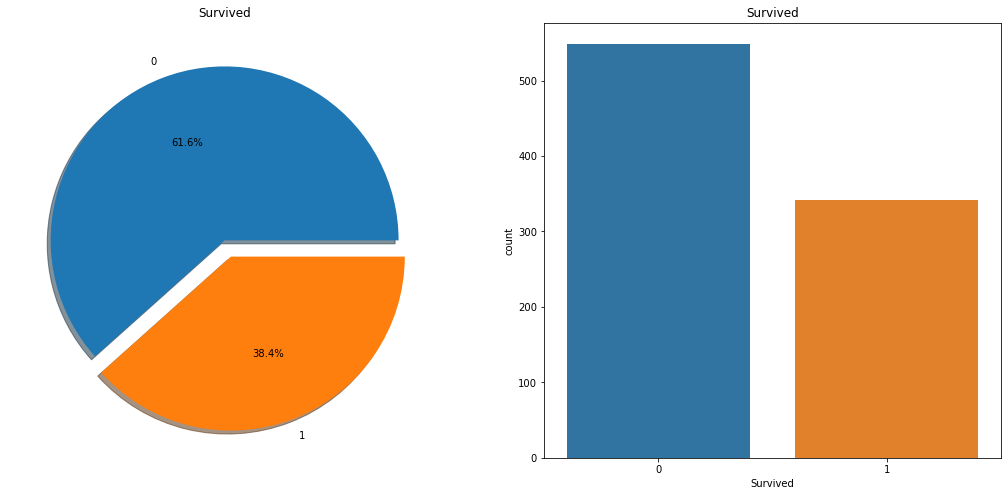

In [8]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_train["Survived"].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title("Survived")
ax[0].set_ylabel('')
sns.countplot("Survived", data=df_train, ax=ax[1])
ax[1].set_title("Survived")
plt.show()

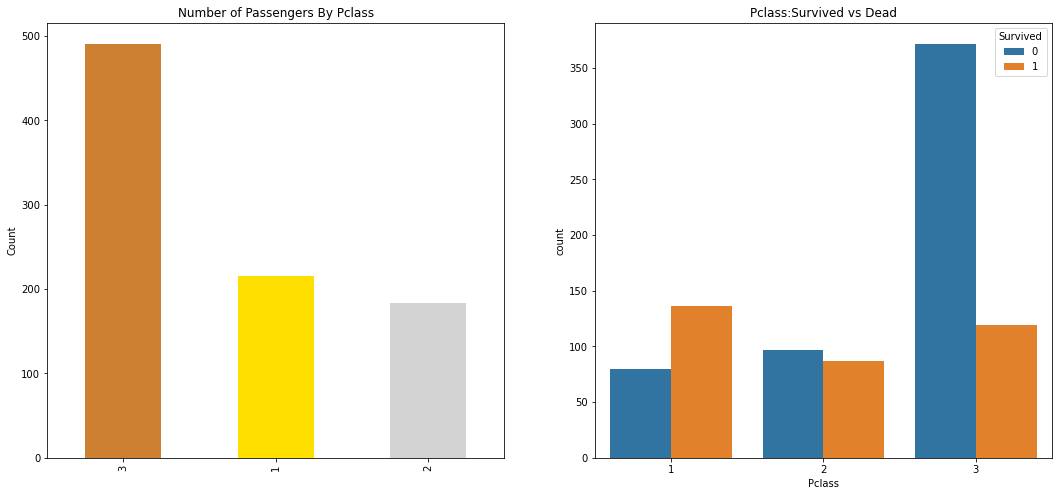

In [9]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_train["Pclass"].value_counts().plot.bar(color=["#CD7F32","#FFDF00","#D3D3D3"],ax=ax[0])
ax[0].set_title("Number of Passengers By Pclass")
ax[0].set_ylabel("Count")
sns.countplot("Pclass",hue="Survived",data=df_train,ax=ax[1])
ax[1].set_title("Pclass:Survived vs Dead")
plt.show()

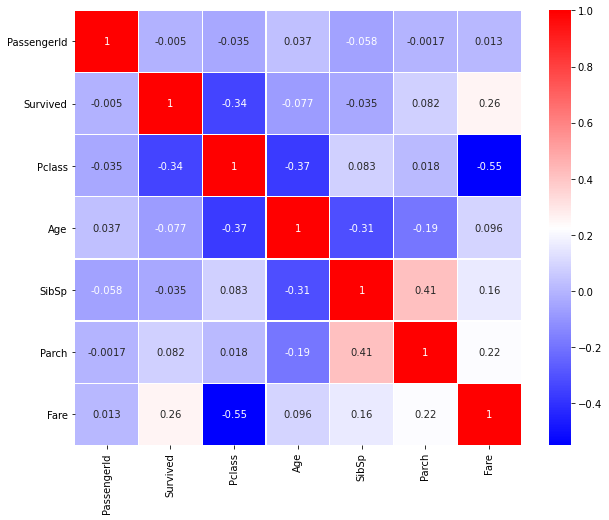

In [10]:
sns.heatmap(df_train.corr(),annot=True,cmap="bwr",linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

## 4.Preprocess

In [11]:
df_alldata.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [12]:
df_alldata.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [13]:
# S多数の為Sで欠損値を埋める
df_alldata.Embarked.fillna("S", inplace=True)
df_alldata.Embarked = df_alldata.Embarked.astype("category")

In [14]:
df_alldata.Cabin.value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
B96 B98            4
C22 C26            4
                  ..
E58                1
A7                 1
C105               1
C118               1
D40                1
Name: Cabin, Length: 186, dtype: int64

In [15]:
df_alldata['Sex'] = df_alldata.Sex.astype('category')

In [16]:
#CabinからDeckを作成、グループにまとめる
df_alldata["Deck"] = df_alldata.Cabin.apply(lambda x: x[0] if pd.notnull(x) else "M")

df_alldata.loc[df_alldata.Deck == "T", "Deck"] = "A"
df_alldata.Deck.replace(["A", "B", "C"], "ABC", inplace=True)
df_alldata.Deck.replace(["D", "E"], "DE", inplace=True)
df_alldata.Deck.replace(["F", "G"], "FG", inplace=True)

display(df_alldata.Deck.value_counts())
df_alldata.Deck = df_alldata.Deck.astype("category")

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

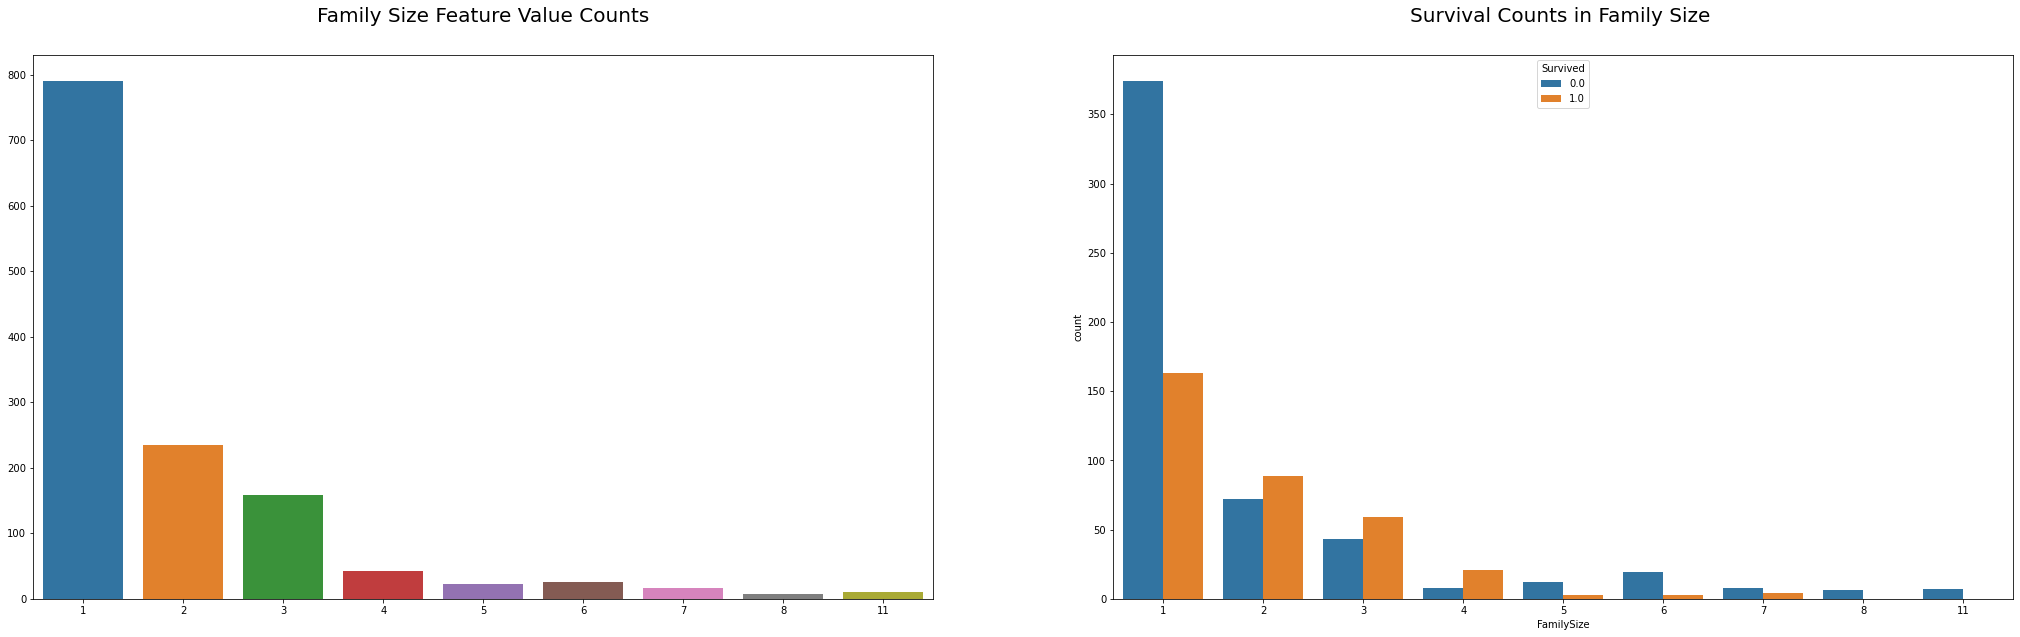

In [17]:
#SibSpとParchからFamilySizeを生成
df_alldata["FamilySize"] = df_alldata.SibSp + df_alldata.Parch + 1

fig, ax = plt.subplots(figsize=(20, 10), ncols=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_alldata.FamilySize.value_counts().index, y=df_alldata.FamilySize.value_counts().values, ax=ax[0])
sns.countplot(x="FamilySize", hue="Survived", data=df_alldata, ax=ax[1])

ax[0].set_title("Family Size Feature Value Counts", size=20, y=1.05)
ax[1].set_title("Survival Counts in Family Size ", size=20, y=1.05)
plt.show()

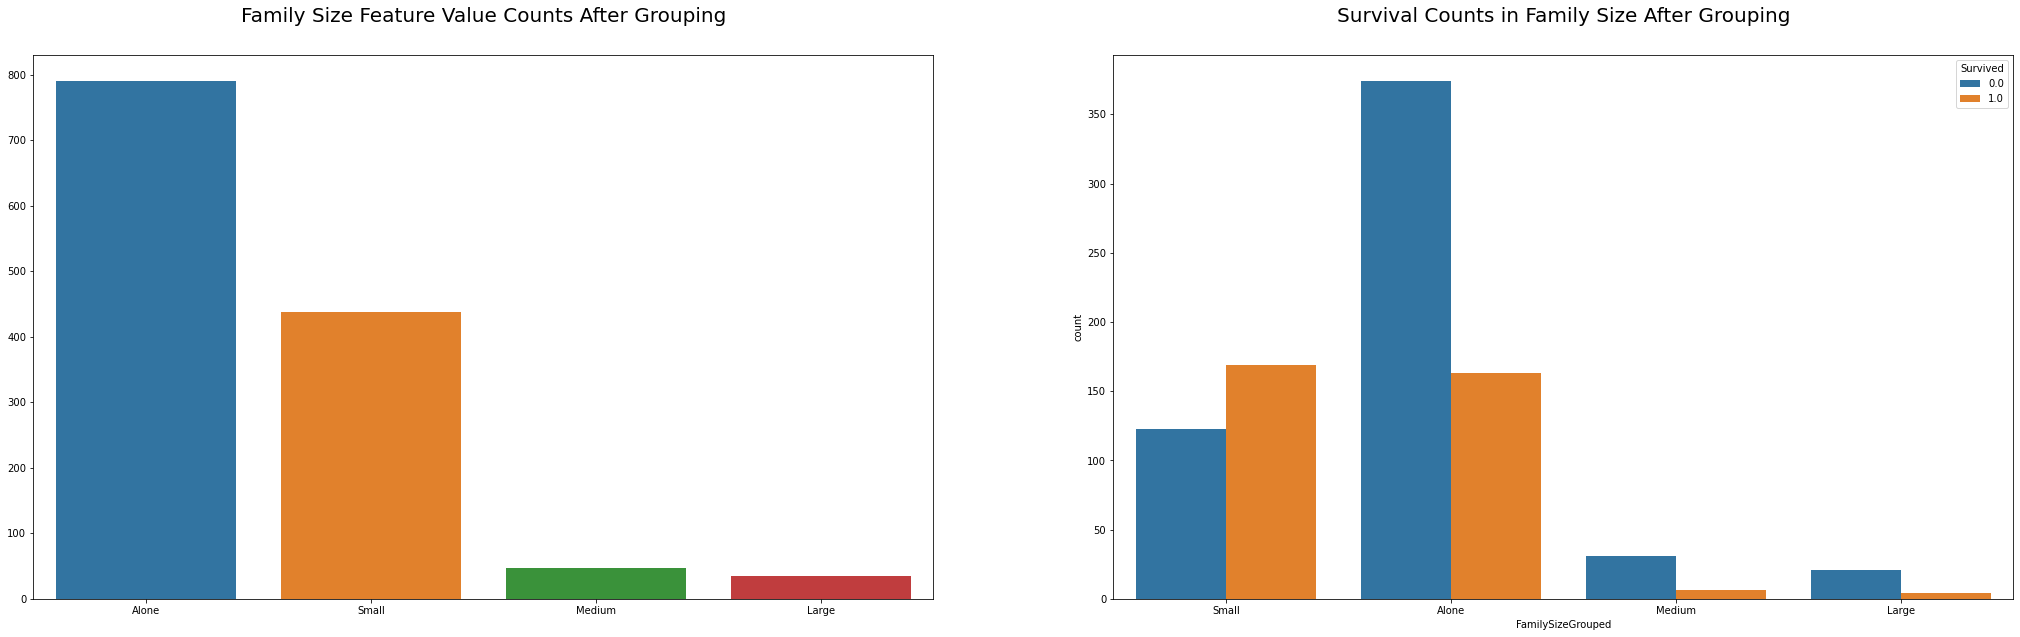

In [18]:
family_map = {1: "Alone", 2: "Small", 3: "Small", 4: "Small", 5: "Medium", 6: "Medium", 7: "Large", 8: "Large", 11: "Large"}
df_alldata["FamilySizeGrouped"] = df_alldata.FamilySize.map(family_map)

fig, ax = plt.subplots(figsize=(20, 10), ncols=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_alldata.FamilySizeGrouped.value_counts().index, y=df_alldata.FamilySizeGrouped.value_counts().values, ax=ax[0])
sns.countplot(x="FamilySizeGrouped", hue="Survived", data=df_alldata, ax=ax[1])

ax[0].set_title("Family Size Feature Value Counts After Grouping", size=20, y=1.05)
ax[1].set_title("Survival Counts in Family Size After Grouping", size=20, y=1.05)
df_alldata.FamilySizeGrouped = df_alldata.FamilySizeGrouped.astype("category")
plt.show()

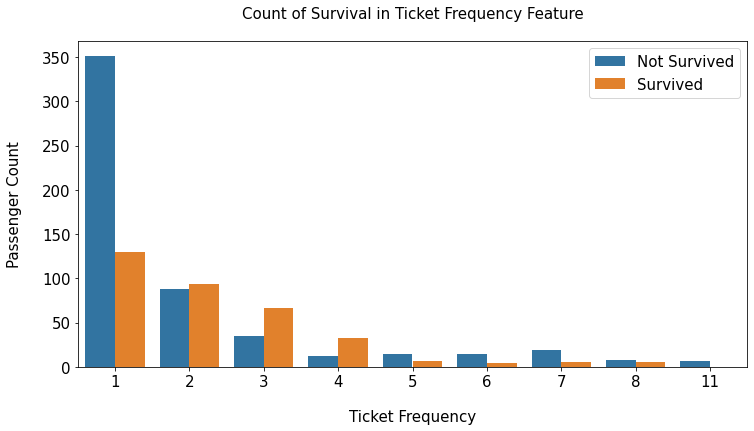

In [19]:
df_alldata["TicketFrequency"] = df_alldata.groupby("Ticket")["Ticket"].transform("count")

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="TicketFrequency", hue="Survived", data=df_alldata)

plt.xlabel("Ticket Frequency", size=15, labelpad=20)
plt.ylabel("Passenger Count", size=15, labelpad=20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

plt.legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 15})
plt.title("Count of Survival in Ticket Frequency Feature", size=15, y=1.05)

plt.show()

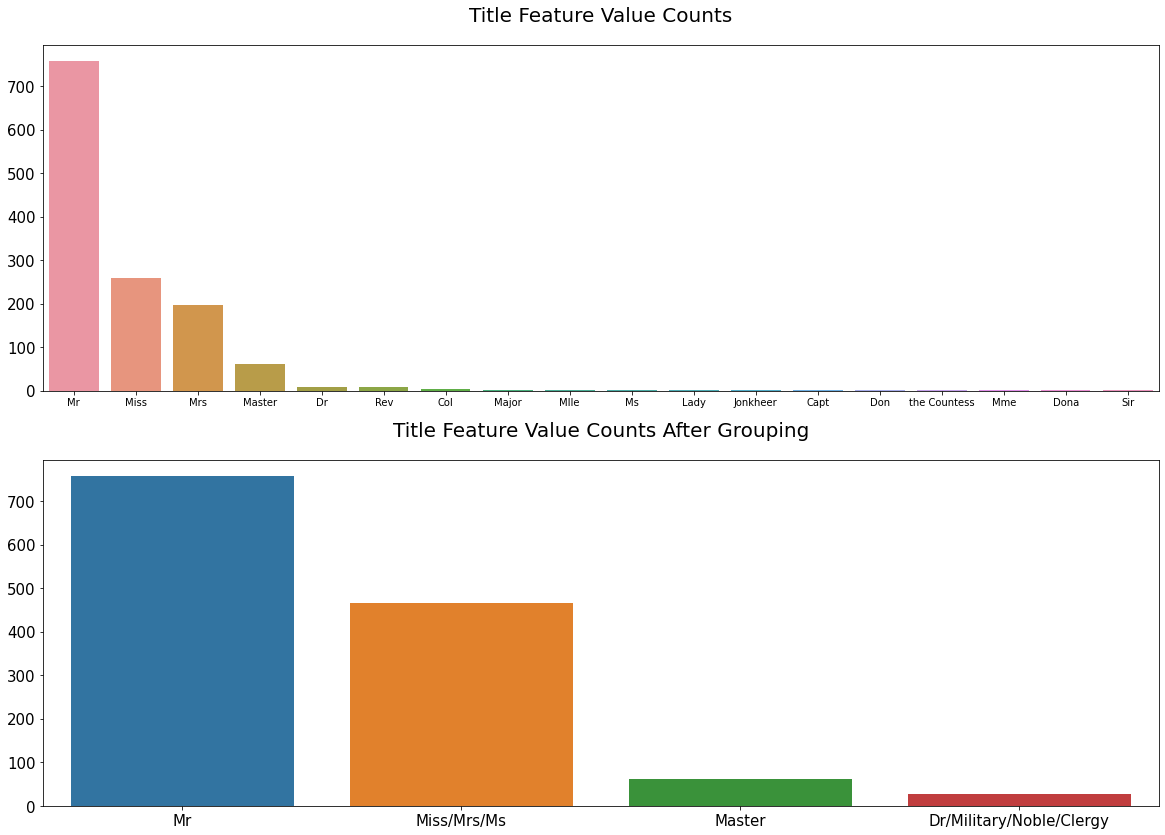

In [20]:
df_alldata["Title"] = df_alldata.Name.str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_alldata["IsMarried"] = 0
df_alldata.loc[df_alldata.Title =="Mrs", "IsMarried"] = 1

fig, ax = plt.subplots(nrows=2, figsize=(20, 14))
sns.barplot(x=df_alldata.Title.value_counts().index, y=df_alldata.Title.value_counts().values, ax=ax[0])

ax[0].tick_params(axis="x", labelsize=10)
ax[1].tick_params(axis="x", labelsize=15)

for i in range(2):    
    ax[i].tick_params(axis="y", labelsize=15)

ax[0].set_title("Title Feature Value Counts", size=20, y=1.05)

df_alldata['TitleGrouped'] = df_alldata.Title.replace(["Miss", "Mrs","Ms", "Mlle", "Lady", "Mme", "the Countess", "Dona"], "Miss/Mrs/Ms")
df_alldata["TitleGrouped"].replace(["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"], "Dr/Military/Noble/Clergy", inplace=True)

sns.barplot(x=df_alldata.TitleGrouped.value_counts().index, y=df_alldata.TitleGrouped.value_counts().values, ax=ax[1])
ax[1].set_title("Title Feature Value Counts After Grouping", size=20, y=1.05)

plt.show()

In [21]:
df_alldata.TitleGrouped = df_alldata.TitleGrouped.astype("category")

In [22]:
df_alldata.Name.unique()

array(['Braund, Mr. Owen Harris', 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Heikkinen, Miss. Laina', ..., 'Saether, Mr. Simon Sivertsen', 'Ware, Mr. Frederick',
       'Peter, Master. Michael J'], dtype=object)

In [23]:
def extract_surname(data):    
    families = []
    for i in range(len(data)):        
        name = data.iloc[i]
        if "(" in name:
            name_no_bracket = name.split("(")[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]
        
        for c in string.punctuation:
            family = family.replace(c, "").strip()
            
        families.append(family)
    return families

df_alldata["Family"] = extract_surname(df_alldata.Name)

In [24]:
df_train = df_alldata[:len(df_train)]
df_test = df_alldata[len(df_train):]

# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train["Family"].unique() if x in df_test["Family"].unique()]
non_unique_tickets = [x for x in df_train["Ticket"].unique() if x in df_test["Ticket"].unique()]

df_family_survival_rate = df_train.groupby("Family")["Survived", "Family", "FamilySize"].median()
df_ticket_survival_rate = df_train.groupby("Ticket")["Survived", "Ticket", "TicketFrequency"].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [25]:
mean_survival_rate = np.mean(df_train["Survived"])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train["Family"][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train["Family"][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test["Family"].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test["Family"].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train.loc[:, "FamilySurvivalRate"] = train_family_survival_rate
df_train.loc[:, "FamilySurvivalRateNA"] = train_family_survival_rate_NA
df_test.loc[:, "FamilySurvivalRate"] = test_family_survival_rate
df_test.loc[:, "FamilySurvivalRateNA"] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train["Ticket"][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train["Ticket"][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test["Ticket"].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test["Ticket"].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train.loc[:, "TicketSurvivalRate"] = train_ticket_survival_rate
df_train.loc[:, "TicketSurvivalRateNA"] = train_ticket_survival_rate_NA
df_test.loc[:, "TicketSurvivalRate"] = test_ticket_survival_rate
df_test.loc[:, "TicketSurvivalRateNA"] = test_ticket_survival_rate_NA

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
for df in [df_train, df_test]:
    df.loc[:, 'SurvivalRate'] = (df['TicketSurvivalRate'] + df['FamilySurvivalRate']) / 2
    df.loc[:, 'SurvivalRateNA'] = (df['TicketSurvivalRateNA'] + df['FamilySurvivalRateNA']) / 2    
df_alldata = pd.concat([df_train, df_test], sort=True, ignore_index=True)

In [27]:
age_by_pclass_sex = df_alldata.groupby(["Sex", "Pclass"]).median()["Age"]
df_alldata["Age"] = df_alldata.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median())).values

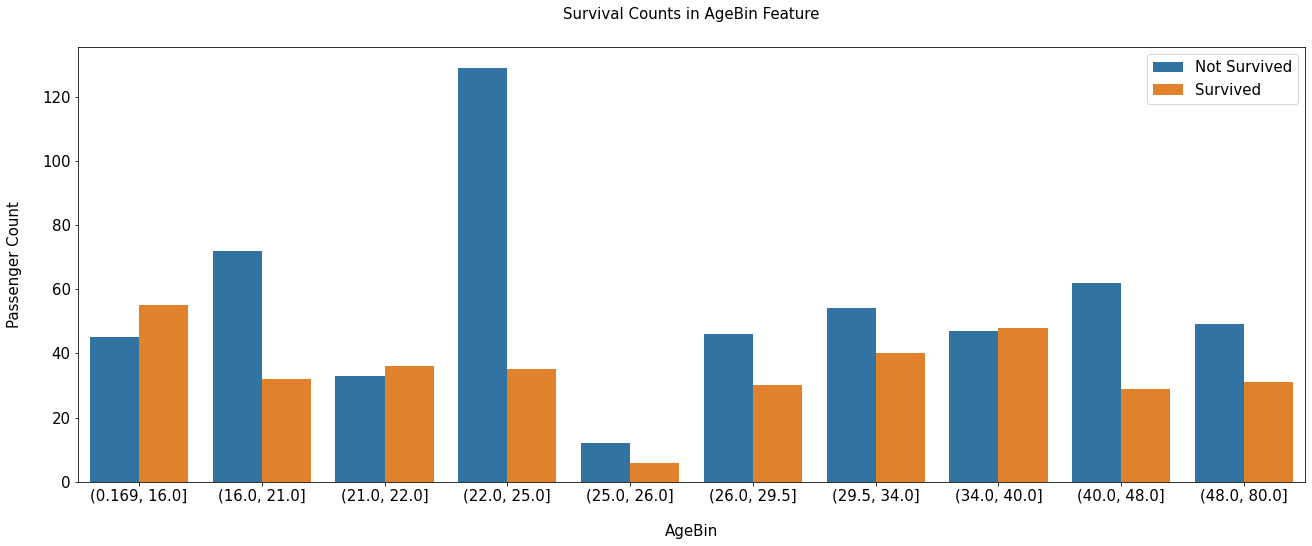

In [28]:
df_alldata["AgeBin"] = pd.qcut(df_alldata["Age"], 10)
plt.figure(figsize=(22, 8))
sns.countplot(x="AgeBin", hue="Survived", data=df_alldata)

plt.xlabel("AgeBin", size=15, labelpad=20)
plt.ylabel("Passenger Count", size=15, labelpad=20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

plt.legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 15})
plt.title("Survival Counts in AgeBin Feature", size=15, y=1.05)

plt.show()

In [29]:
df_alldata["AgeBin"] = LabelEncoder().fit_transform(df_alldata["AgeBin"])

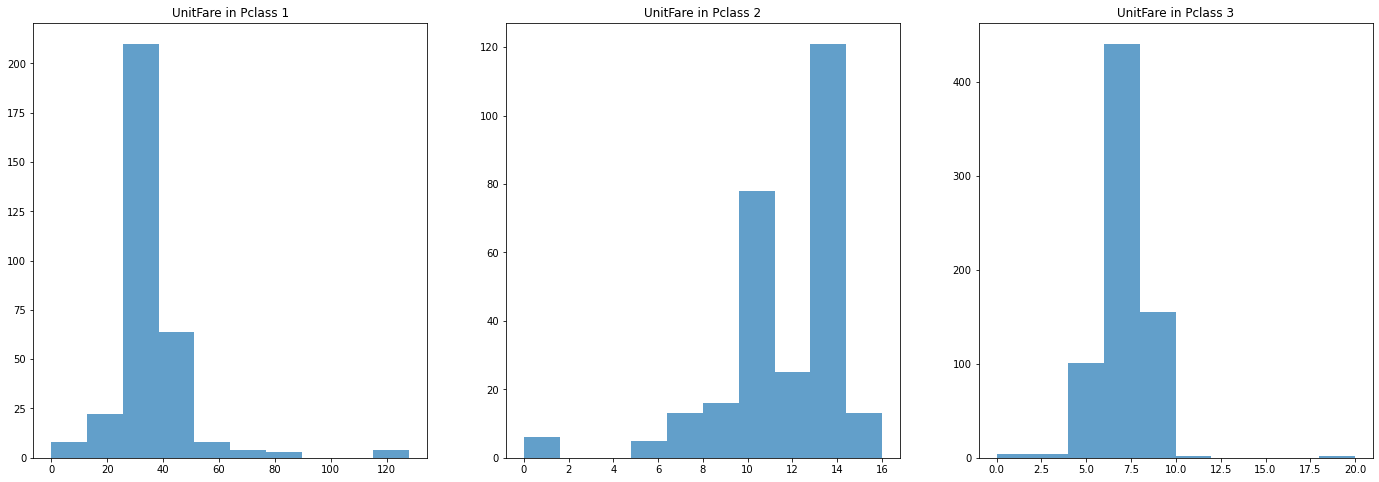

In [30]:
# 欠損値をPclass, Parch, SibSpのグループの中央値で埋める
med_fare = df_alldata.groupby(["Pclass", "Parch", "SibSp"]).Fare.median()[3][0][0]
df_alldata["Fare"] = df_alldata["Fare"].fillna(med_fare)

# 一人ごとの運賃に変換
df_alldata["UnitFare"] = df_alldata["Fare"] / df_alldata["TicketFrequency"]

f, ax = plt.subplots(1, 3, figsize=(24, 8))

ax[0].hist(df_alldata[df_alldata.Pclass==1].UnitFare, alpha=0.7)
ax[0].set_title("UnitFare in Pclass 1")

ax[1].hist(df_alldata[df_alldata.Pclass==2].UnitFare, alpha=0.7)
ax[1].set_title("UnitFare in Pclass 2")

ax[2].hist(df_alldata[df_alldata.Pclass==3].UnitFare, alpha=0.7)
ax[2].set_title("UnitFare in Pclass 3")

plt.show()

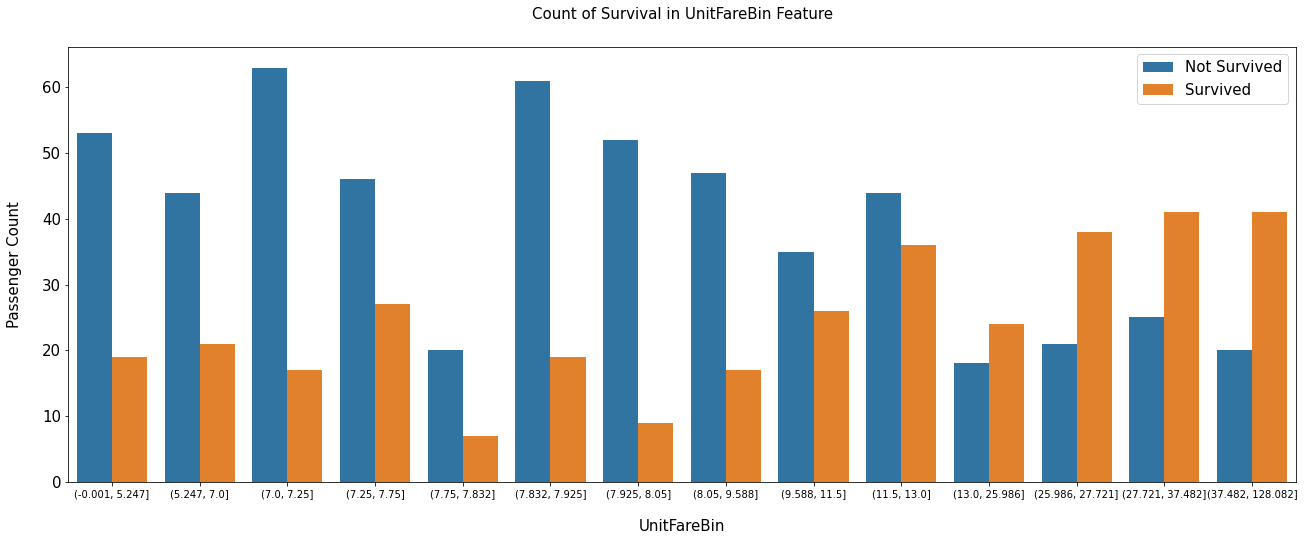

In [31]:
df_alldata.loc[(df_alldata.Pclass==3)&(df_alldata.UnitFare>15), "UnitFare"] = df_alldata[(df_alldata.Pclass==3)&(df_alldata.UnitFare>15)]["UnitFare"] / 2


df_alldata["UnitFareBin"] = pd.qcut(df_alldata["UnitFare"], 14)

plt.figure(figsize=(22, 8))
sns.countplot(x="UnitFareBin", hue="Survived", data=df_alldata)

plt.xlabel("UnitFareBin", size=15, labelpad=20)
plt.ylabel("Passenger Count", size=15, labelpad=20)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=15)

plt.legend(["Not Survived", "Survived"], loc="upper right", prop={"size": 15})
plt.title("Count of Survival in UnitFareBin Feature", size=15, y=1.05)

plt.show()

In [32]:
df_alldata["UnitFareBin"] = LabelEncoder().fit_transform(df_alldata["UnitFareBin"])

In [33]:
# 特徴量
features = ["AgeBin", "Deck", "Embarked", "FamilySizeGrouped", "UnitFareBin", 
    "IsMarried", "Pclass", "Sex", "SurvivalRate", "SurvivalRateNA", 
    "TicketFrequency", "TitleGrouped"]

# 目的変数
target = "Survived"

df_alldata = df_alldata[features+[target]]
df_alldata.head(3)

,AgeBin,Deck,Embarked,FamilySizeGrouped,UnitFareBin,IsMarried,Pclass,Sex,SurvivalRate,SurvivalRateNA,TicketFrequency,TitleGrouped,Survived
0,2,M,S,Small,2,0,3,male,0.383838,0.0,1,Mr,0.0
1,7,ABC,C,Small,12,1,1,female,1.000000,1.0,2,Miss/Mrs/Ms,1.0
2,4,M,S,Alone,5,0,3,female,0.383838,0.0,1,Miss/Mrs/Ms,1.0


Categorical variables: ['Deck' 'Embarked' 'FamilySizeGrouped' 'Sex' 'TitleGrouped']
Numeric variables: {'IsMarried', 'UnitFareBin', 'TicketFrequency', 'SurvivalRateNA', 'Pclass', 'SurvivalRate', 'AgeBin'}


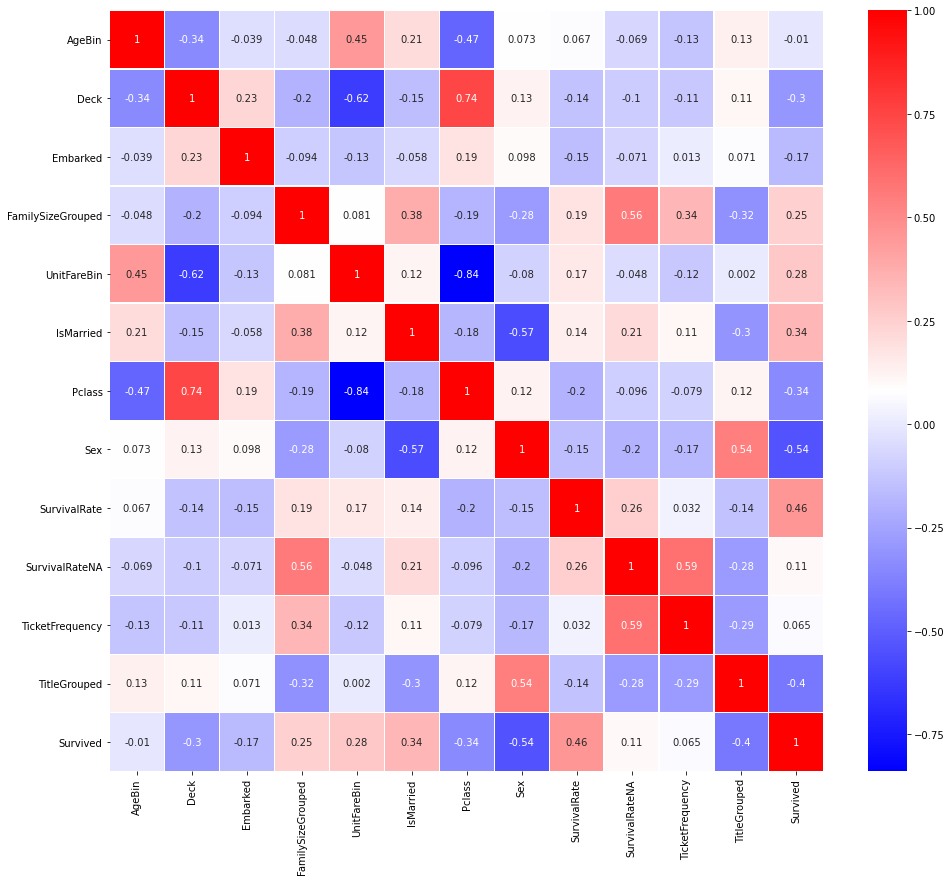

In [34]:
# カテゴリカル変数
cat_features = df_alldata.select_dtypes(include="category").columns.values
print("Categorical variables:", cat_features)
print("Numeric variables:", set(features) - set(cat_features))

# カテゴリカル変数をLabel-encoding
df_le = pd.DataFrame()
for feature in features:
    if feature in cat_features:
        df = df_alldata[feature]
        df_le[feature] =  LabelEncoder().fit_transform(df_alldata[feature])
    else:
        df_le[feature] = df_alldata[feature].values
df_le["Survived"] = df_alldata.Survived.values

sns.heatmap(df_le.corr(), annot=True, cmap="bwr", linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(16, 14)
plt.show()

In [37]:
# One-hot Encoding
df_alldata = pd.get_dummies(df_alldata, columns=cat_features)

In [38]:
# trainデータとtestデータに分割
X_train = df_alldata[:len(df_train)].copy()
X_test = df_alldata[len(df_train):].copy()

X_train.drop('Survived', axis=1, inplace=True)
X_test.drop('Survived', axis=1, inplace=True)

y_train = df_alldata[:len(df_train)]['Survived']

print('X_train', X_train.shape, 'X_test', X_test.shape)
print('y_train', y_train.shape)

X_train (891, 24) X_test (418, 24)
y_train (891,)


In [44]:
params = {
        "criterion": "gini",
        "n_estimators": 226,
        "max_depth": 5,
        "min_samples_split": 9,
        "min_samples_leaf": 4,
        "max_features": "auto",
        "random_state": 1,
        "n_jobs": -1
    }

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
valid_preds = np.zeros((X_train.shape[0]))
test_preds = np.zeros((5, X_test.shape[0]))
importances = np.zeros((5, X_train.shape[1]))
acc_list = {'train': [], 'valid': []}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    model = RandomForestClassifier(**params)
    model.fit(X_tr, y_tr)

    pred_train = model.predict_proba(X_tr)[:,1]
    pred_train = (pred_train > 0.5).astype(int)
    train_acc = accuracy_score(y_tr, pred_train)
    acc_list['train'].append(train_acc)

    pred_val = model.predict_proba(X_val)[:,1]
    valid_preds[valid_index] = pred_val
    pred_val = (pred_val > 0.5).astype(int)
    val_acc = accuracy_score(y_val, pred_val)
    acc_list['valid'].append(val_acc)

    pred_test = model.predict_proba(X_test)[:,1]
    test_preds[fold_id] = pred_test

    importances[fold_id] = model.feature_importances_

print("---CV scores---")
print("train cv acc", acc_list["train"])
print("valid cv acc", acc_list["valid"])
print("train acc", np.mean(acc_list["train"]))
print("valid acc", np.mean(acc_list["valid"]))

---CV scores---
train cv acc [0.8581460674157303, 0.8583450210378681, 0.8625525946704067, 0.8653576437587658, 0.8653576437587658]
valid cv acc [0.8659217877094972, 0.8876404494382022, 0.8595505617977528, 0.8033707865168539, 0.8146067415730337]
train acc 0.8619517941283072
valid acc 0.846218065407068


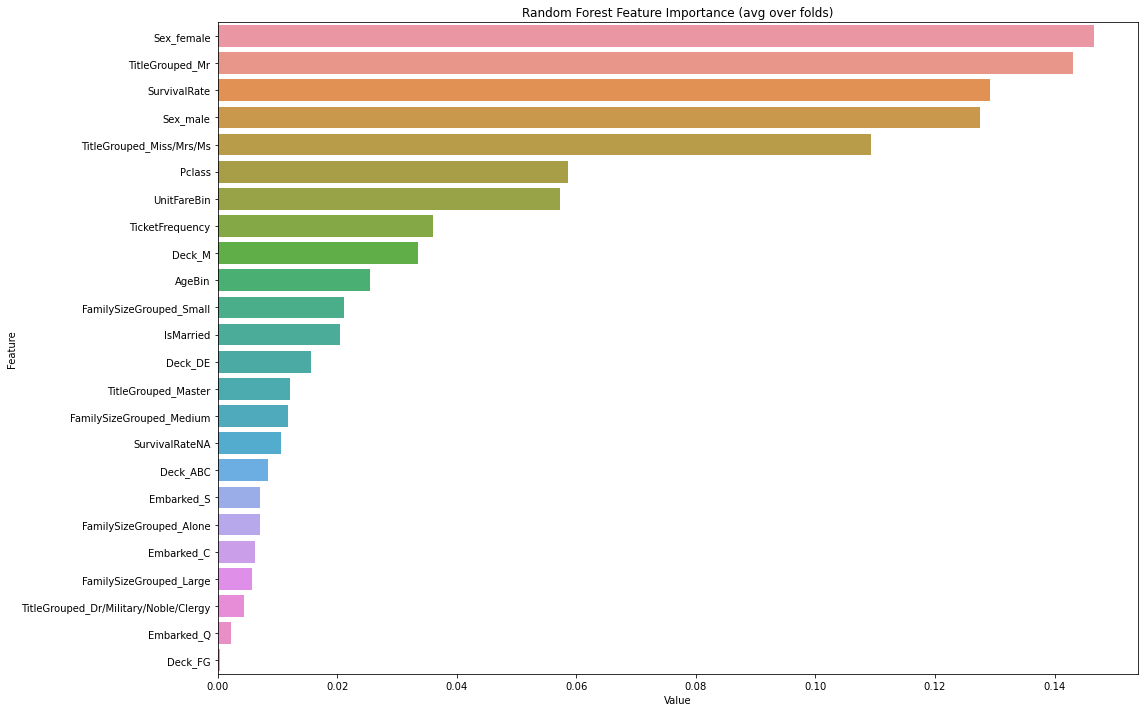

In [46]:
importance = np.mean(importances, axis=0)  # 各foldのimportanceの平均
importance_df = pd.DataFrame({"Feature": X_train.columns, "Value": importance})

plt.figure(figsize=(16, 10))
sns.barplot(x="Value", y="Feature", data=importance_df.sort_values(by="Value", ascending=False))
plt.title("Random Forest Feature Importance (avg over folds)")
plt.tight_layout()
plt.show()

In [47]:
test_preds = np.mean(test_preds, axis=0)
test_preds = (test_preds > 0.5).astype(int)

# 提出フォーマットに合わせる
sub = pd.DataFrame(pd.read_csv('titanic/gender_submission.csv')['PassengerId'])
sub['Survived'] = test_preds

sub.to_csv('submit.csv', index=False)
print(sub.head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
